In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from collections import OrderedDict as odict
import warnings
import datetime
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('data_synth_train.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
# Estrai ore e minuti e convertili in un numero totale di minuti
df['timestamp_in_seconds'] = df['timestamp'].dt.hour * 3600 + df['timestamp'].dt.minute * 60 + df['timestamp'].dt.second

In [5]:
df_melted = df.melt(id_vars=['timestamp_in_seconds'], value_vars=["Living room","Bedroom","Bathroom","Kitchen","Hallway"],
                    var_name='feature', value_name='value')

In [6]:
df_filtered = df_melted[df_melted['value'] == 1]

/home/fabio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


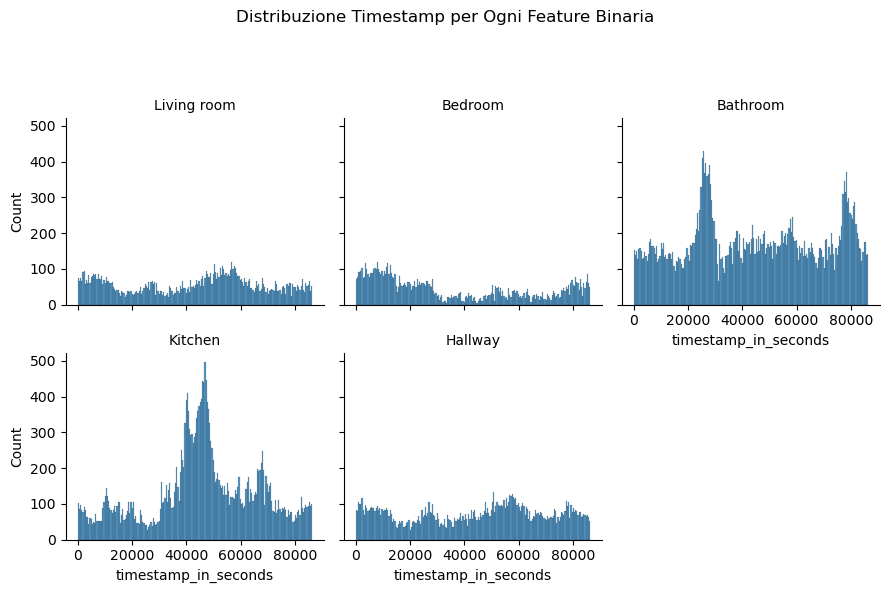

<Figure size 640x480 with 0 Axes>

In [7]:
g = seaborn.FacetGrid(df_filtered, col='feature', col_wrap=3)  # 'col_wrap' per controllare quante colonne per riga

# Mappa l'istogramma all'ora e minuto per ogni feature
g.map(seaborn.histplot, 'timestamp_in_seconds', bins = 200)

# Regola l'aspetto dei grafici
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Distribuzione Timestamp per Ogni Feature Binaria')

plt.show()


plt.savefig('Distr_temp.png')

In [8]:
df['day'] = df['timestamp'].dt.date

pippo = list(df['day'].unique())

mapping = {i : pippo.index(i) + 1 for i in pippo}


df['var_CO2CosIRValue'] = df['CO2CosIRValue'].pct_change().fillna(0)
df['var_CO2MG811Value'] = df['CO2MG811Value'].pct_change().fillna(0)
df['var_MOX1'] = df['MOX1'].pct_change().fillna(0)
df['varMOX2'] = df['MOX2'].pct_change().fillna(0)
df['var_MOX3'] = df['MOX3'].pct_change().fillna(0)
df['var_MOX4'] = df['MOX4'].pct_change().fillna(0)
df['var_COValue'] = df['COValue'].pct_change().fillna(0)
df['var_temperature'] = df['temperature'].pct_change().fillna(0)
df['var_humidity'] = df['humidity'].pct_change().fillna(0)


df = df.drop(["temperature","humidity","CO2CosIRValue","CO2MG811Value","MOX1","MOX2","MOX3","MOX4","COValue"], axis = 1)



In [9]:
#df['mapping_day'] = mapping[df['date']]

df['mapped_date'] = (df['day'].map(mapping))

c = ["Living room","Bedroom","Bathroom","Kitchen","Hallway"]
c_ = ["Bathroom","Kitchen"]


In [15]:
df = df.drop(["timestamp", "day"], axis = 1)

In [24]:
df.to_csv('clean_data.csv')

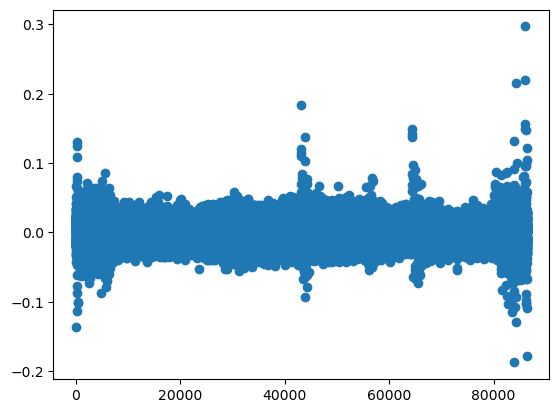

In [23]:
plt.scatter(df['timestamp_in_seconds'].values, df['var_COValue'].values)

In [11]:
to_drop = set()
for i in c_:

   B = df[df[i] == 1].groupby('mapped_date').count()

   dati = B['timestamp'].values

   Q1 = np.percentile(dati, 25)
   Q3 = np.percentile(dati, 75)
   IQR = Q3 - Q1

   # Definizione degli outlier come valori al di fuori di Q1 - 1.5*IQR e Q3 + 1.5*IQR
   outlier_condition = ((dati > (Q3 + 1.8 * IQR)))

   # Recupero degli outlier
   outliers = dati[outlier_condition]

   td = []
   for ol in outliers:
      for j in B[B['timestamp'] == ol].index:
         td.append(j)



   to_drop = to_drop.union(set(td))



In [12]:
td

[3, 8, 11, 34, 36, 49, 53, 57, 59]

In [13]:
# Rimozione degli outliers

df = df[~df['mapped_date'].isin(td)]


In [14]:
df

,timestamp,Living room,Bedroom,Bathroom,Kitchen,Hallway,timestamp_in_seconds,day,var_CO2CosIRValue,var_CO2MG811Value,var_MOX1,varMOX2,var_MOX3,var_MOX4,var_COValue,var_temperature,var_humidity,mapped_date
0,2019-11-07 00:00:07,0,0,0,0,0,7,2019-11-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,2019-11-07 00:00:27,0,0,0,0,0,27,2019-11-07,-0.018349,0.003766,0.010225,0.002837,-0.001517,0.005000,0.000000,-0.003293,0.005023,1
2,2019-11-07 00:00:47,1,0,0,0,0,47,2019-11-07,0.000000,-0.005629,-0.006073,0.001414,-0.003040,-0.011609,-0.008197,-0.003775,-0.008616,1
3,2019-11-07 00:01:07,1,0,0,0,0,67,2019-11-07,-0.009346,0.003774,-0.004073,0.002825,0.000000,0.001678,0.041322,0.000474,0.007127,1
4,2019-11-07 00:01:27,1,0,0,0,0,87,2019-11-07,-0.028302,0.000000,0.002045,-0.007042,0.003049,0.000000,0.031746,-0.002841,0.004142,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304563,2020-01-17 03:51:43,0,0,0,0,0,13903,2020-01-17,0.000000,0.001890,0.004556,-0.002882,0.001538,0.001718,0.000000,0.001817,0.003636,72
304564,2020-01-17 03:52:03,0,0,0,0,0,13923,2020-01-17,0.019608,-0.001887,0.000000,0.002890,0.000000,0.000000,0.000000,-0.005442,-0.001268,72
304565,2020-01-17 03:52:23,0,0,0,0,0,13943,2020-01-17,-0.028846,0.000000,0.004535,0.000000,0.000000,0.001715,0.009259,0.007296,-0.000181,72
304566,2020-01-17 03:52:43,0,0,0,0,0,13963,2020-01-17,0.000000,0.000000,-0.004515,0.000000,0.000000,0.001712,-0.009174,-0.002263,0.001814,72


In [48]:
num_intervalli = 24

# Creazione dei bin (intervalli) utilizzando pd.cut
# np.linspace genera estremi degli intervalli dal minimo al massimo valore nella colonna di interesse
bins = np.linspace(0, 3600*24, num_intervalli + 1)
df['intervalli'] = pd.cut(df['timestamp_in_seconds'], bins=bins, include_lowest=True, labels=[3600*i for i in range(num_intervalli)])

# Raggruppamento per intervallo e calcolo della media della grandezza di interesse
media_per_intervallo = df.groupby('intervalli')['COValue'].mean().reset_index()


media_per_intervallo

,intervalli,COValue
0,0,117.244876
1,3600,113.150469
2,7200,109.037637
3,10800,105.914523
4,14400,102.964444
5,18000,102.353810
6,21600,101.638571
7,25200,101.032696
8,28800,104.367112
9,32400,107.283957


<Axes: ylabel='Count'>

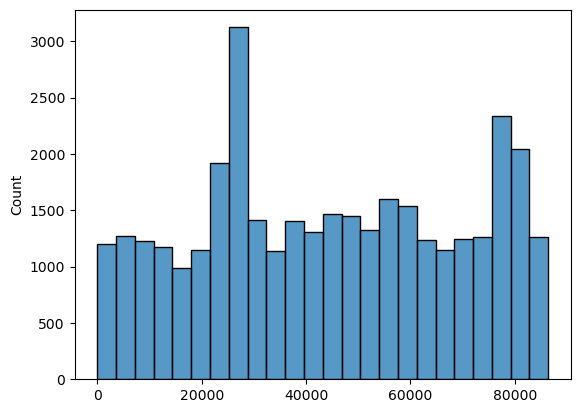

In [50]:
data = df[
        (df[c[2]] == 1)]['hour_minute']





seaborn.histplot(data.values, bins = 24)


